## Project_ML_Professional

Botasheva Zhanna

# Обнаружение аварийных твитов с использованием NLP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
import keras_core as keras
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.15.0
Keras version: 0.1.7


## О датасете

Данный датасет содержит информацию  о более 10 000 твитов, которые были классифицированы вручную.
Необходимо создать модель машинного обучения, которая предскажет, какие твиты посвящены реальным катастрофам, а какие нет.

Сложность работы заключается в том, что полагаться на ключевые слова, такие как "взрыв" или "пожар" не корректно, так как
не всегда слова человека объявляют о катастрофе.

### Посомтрим на набор данных для обучения и тестирования:

* `id`- уникальный идентификатор для каждого твита
* `text` - текст твита
* `location` - место, откуда был отправлен твит (может быть пустым)
* `keyword` - определенное ключевое слово из твита (может быть пустым)
* `target`- только в файле train.csv это означает, посвящен ли твит реальной катастрофе (1) или нет (0)

In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train = pd.read_csv("/content/drive/My Drive/Project/train.csv")
df_test = pd.read_csv("/content/drive/My Drive/Project/test.csv")

print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train.groupby("target").count()

,id,keyword,location,text
target,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


## Предобработка данных

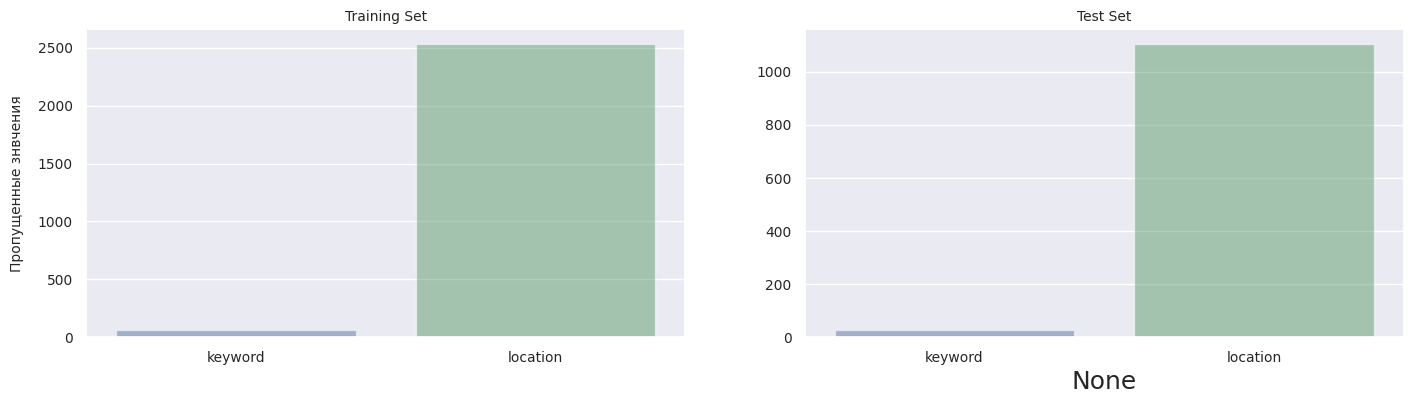

In [ ]:
#Пропущенные знвчения

missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=train[missing_cols].isnull().sum().index, y=train[missing_cols].isnull().sum().values, ax=axes[0], palette=["C0", "C2"], alpha=0.5)
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1], palette=["C0", "C2"], alpha=0.5)

axes[0].set_xlabel('')
axes[0].set_ylabel('Пропущенные знвчения', size=10, labelpad=10)
axes[0].tick_params(axis='x', labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

axes[0].set_title('Training Set', fontsize=10)
axes[1].set_title('Test Set', fontsize=10)

plt.show()

for df in [train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

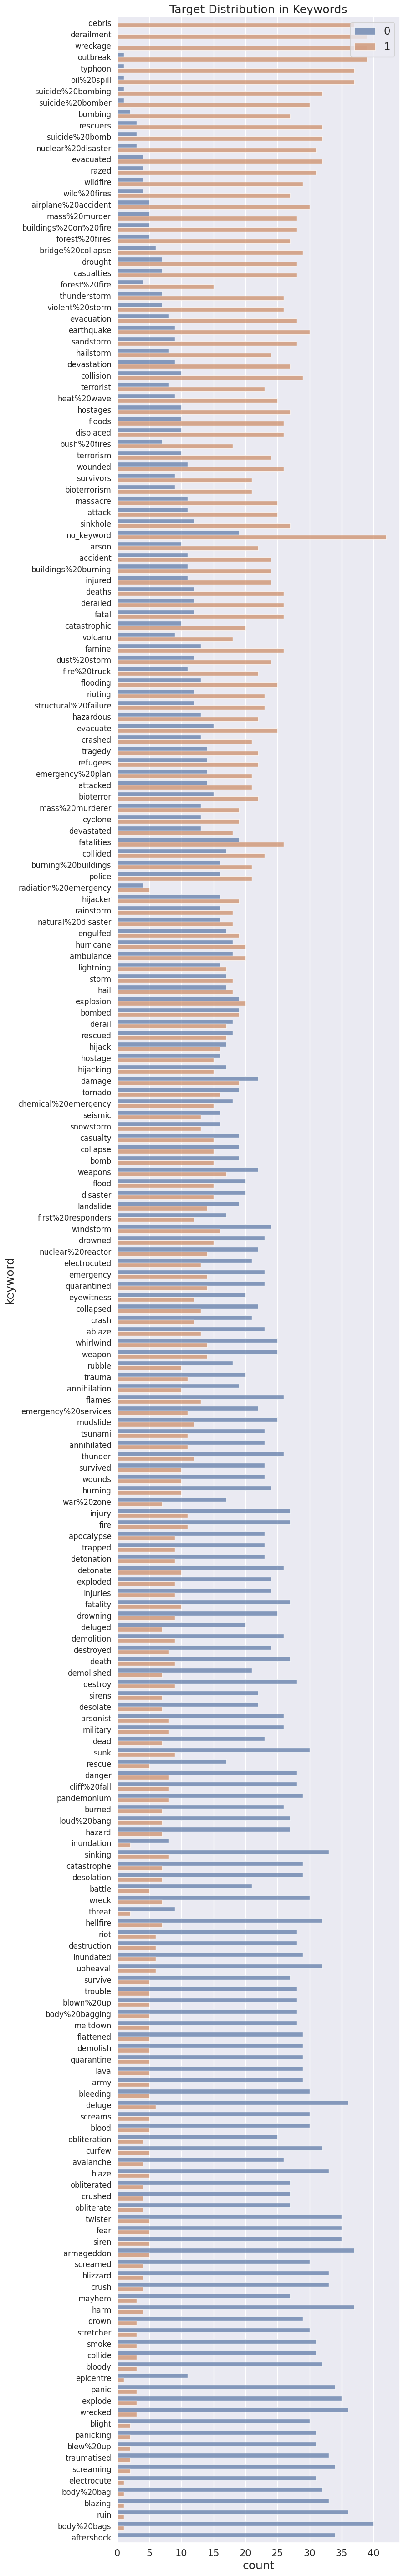

In [ ]:
# Распределение ключевого слова в зависимости от посвящен ли твит реальной катастрофе (1) или нет (0)

train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'], alpha=0.7)

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1


Удалим столбцы `id`, `keyword` и `location`, так как для дальнейшей работы они нам не нужны.

In [ ]:
train=train.drop('keyword', axis=1)
train=train.drop('location', axis=1)
train=train.drop('id', axis=1)

Сделаем копию датасета, она нам пригодится при построении модели DistilBert.

In [ ]:
df_train=train.copy()

Твиты о стихийных бедствиях написаны более формально и содержат более длинные слова по сравнению с твитами, не связанными со стихийными бедствиями, возможно из-за того, что о них узнают от информационных агентств. Твиты, не связанные со стихийными бедствиями, содержат больше опечаток, чем твиты, связанные со стихийными бедствиями. Проанализируем:

* `word_count` количество слов в тексте
* `unique_word_count` количество уникальных слов в тексте
* `stop_word_count` количество стоп-слов в тексте
* `url_count` количество URL-адресов в тексте
* `mean_word_length` среднее количество символов в словах
* `char_count` количество символов в тексте
* `punctuation_count` количество знаков препинания в тексте
* `hashtag_count` количество хэштегов (#) в тексте
* `mention_count` количество упоминаний (@) в тексте

In [ ]:
import nltk   # Natural Language Toolkit
from nltk.corpus import stopwords
# загружаем список стоп-слов для английского
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# примеры стоп-слов
print(len(stop_words))
print(stop_words[:20])

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import string

# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

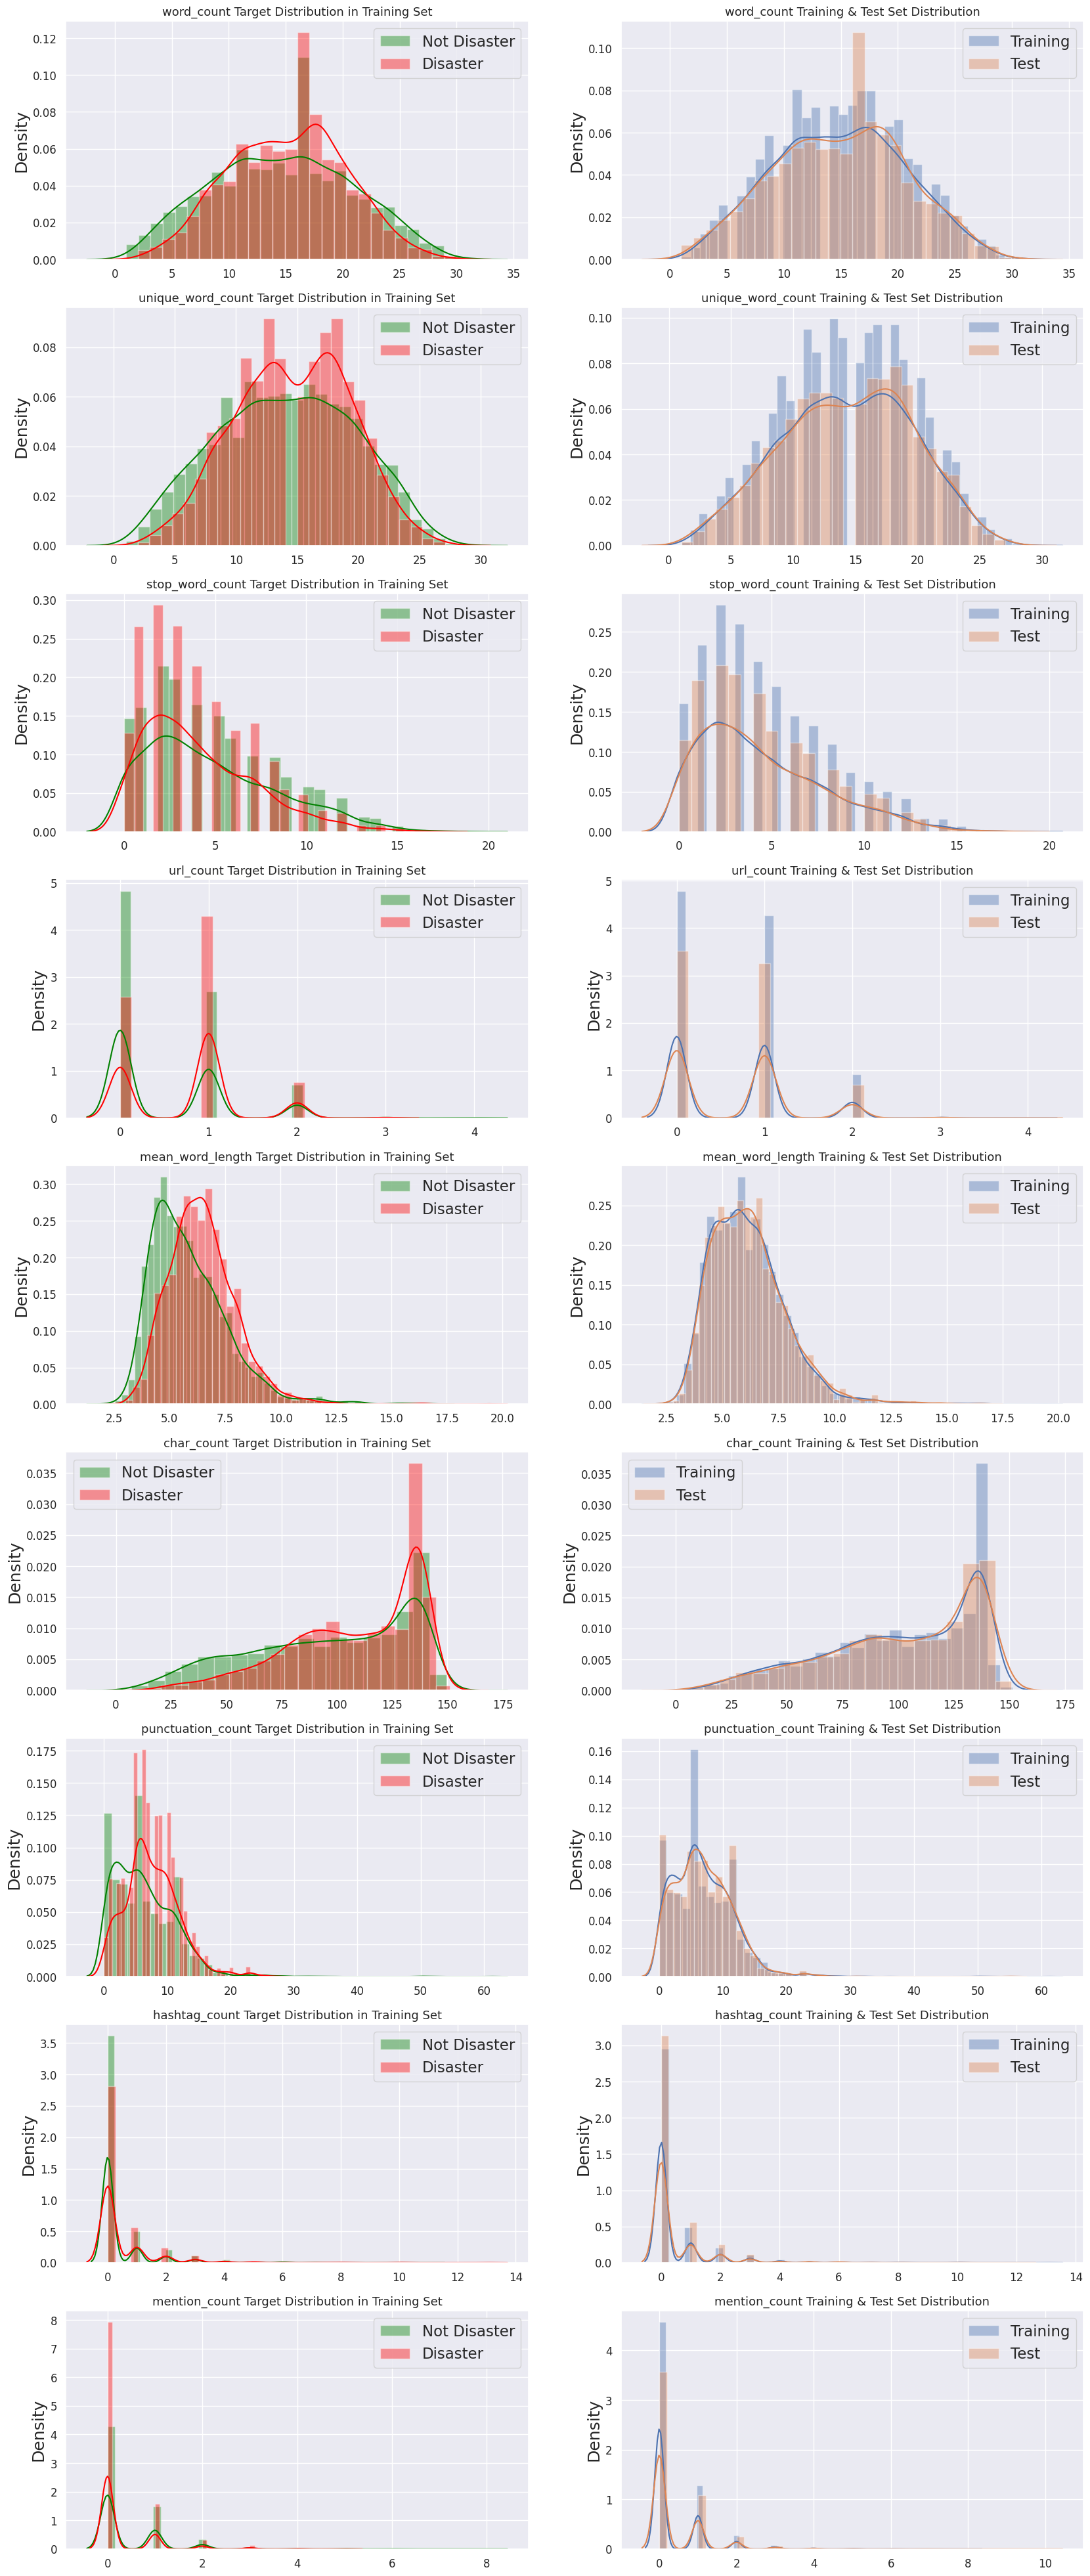

In [ ]:
#Распределение метафункций в обучающем и тестовом наборах

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

Все мета-функции имеют очень схожее распределение в обучающем и тестовом наборах.

In [ ]:
df_train['text'].values[5]

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

In [ ]:
#Удалим все нерелевантные символы

import re

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"@\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"#", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"@", "at", regex=True)
    df[text_field] = df[text_field].str.replace(r"%20", "at", regex=True)
    df[text_field] = df[text_field].str.lower()
    return df

df_train = standardize_text(df_train, "text")

df_train.to_csv("clean_train.csv")
df_train.head(5)

,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,our deeds are the reason of this earthquake m...,1,13,13,6,0,4.384615,69,1,1,0
1,forest fire near la ronge sask canada,1,7,7,0,0,4.571429,38,1,0,0
2,all residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,133,3,0,0
3,"13,000 people receive wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0
4,just got sent this photo from ruby alaska as ...,1,16,15,7,0,4.500000,88,2,2,0


In [ ]:
df_train['text'].values[5]

' rockyfire update    california hwy  20 closed in both directions due to lake county fire    cafire  wildfires'

In [ ]:
#Лемматизация

from string import punctuation
from pymystem3 import Mystem

mystem = Mystem()

def lemmatize_and_filter(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and not token.isnumeric() \
              and token != " " \
              and token.strip() not in punctuation]

    text = " ".join(tokens)

    return text

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
lemmatize_and_filter(train['text'].values[5])

'rockyfire update california hwy closed directions due lake county fire cafire wildfires'

In [ ]:
#from nltk.stem.snowball import SnowballStemmer

# инициализируем стеммер
#stemmer = SnowballStemmer("english")
#def stemmed(text):
    #text = " ".join([stemmer.stem(token) for token in text.split(' ')])

    #return text

In [ ]:
#Сделаем теперь предобработку.
#data_preprocessed['text'] = df_train['text'].apply(lambda text: stemmed(lemmatize_and_filter(text)))
df_train['text_cleaned'] = df_train['text'].apply(lambda text: lemmatize_and_filter(text))
df_train['text_cleaned'].values[5]

'rockyfire update california hwy closed directions due lake county fire cafire wildfires'

In [ ]:
#df_mislabeled = df_train.groupby(['text_cleaned']).nunique().sort_values(by='target', ascending=False)
#df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
#df_mislabeled.index.tolist()

In [ ]:
#df_train['target_relabeled'] = df_train['target'].copy()
#df_train.loc[df_train['text_cleaned'] == 'foodscare offers2go nestleindia slips loss magginoodle ban unsafe hazardous humanconsumption', 'target_relabeled'] = 0

In [ ]:
#Токенизация
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df_train["tokens"] = df_train["text_cleaned"].apply(tokenizer.tokenize)
df_train.head()

,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,text_cleaned,tokens
0,our deeds are the reason of this earthquake m...,1,13,13,6,0,4.384615,69,1,1,0,deeds reason earthquake may allah forgive us,"[deeds, reason, earthquake, may, allah, forgiv..."
1,forest fire near la ronge sask canada,1,7,7,0,0,4.571429,38,1,0,0,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,133,3,0,0,residents asked shelter place notified officer...,"[residents, asked, shelter, place, notified, o..."
3,"13,000 people receive wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0,people receive wildfires evacuation orders cal...,"[people, receive, wildfires, evacuation, order..."
4,just got sent this photo from ruby alaska as ...,1,16,15,7,0,4.500000,88,2,2,0,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [ ]:
df_train['tokens'].values[5]

['rockyfire',
 'update',
 'california',
 'hwy',
 'closed',
 'directions',
 'due',
 'lake',
 'county',
 'fire',
 'cafire',
 'wildfires']

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in df_train["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df_train["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s всего слов, при объеме словарного запаса  %s" % (len(all_words), len(VOCAB)))
print("Max длина предложения %s" % max(sentence_lengths))

66587 всего слов, при объеме словарного запаса  14236
Max длина предложения 23


In [ ]:
print(all_words)
print(VOCAB)

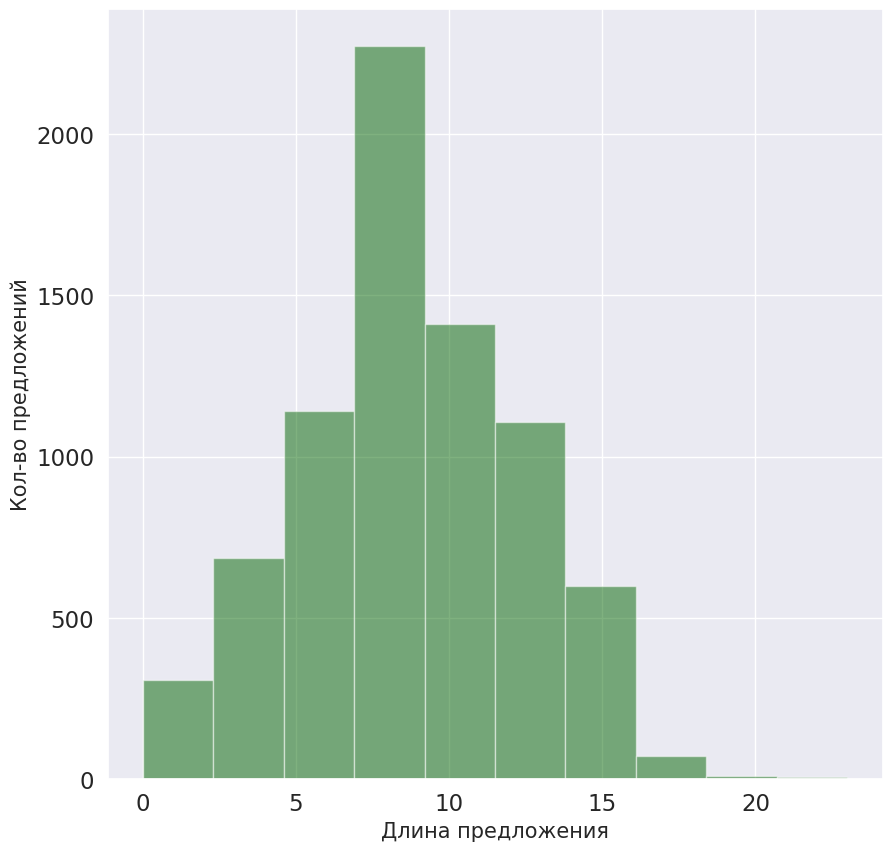

In [ ]:
#Длина предложения и кол-во предложений
fig = plt.figure(figsize=(10, 10))
plt.xlabel('Длина предложения', fontsize=15)
plt.ylabel('Кол-во предложений', fontsize=15)
plt.hist(sentence_lengths, color = 'darkgreen',  alpha=0.5)
plt.show()


Естественным способом представления текста для компьютеров является кодирование каждого символа по отдельности, это кажется совершенно недостаточным для представления и понимания языка. Наша цель - сначала создать полезное вложение для каждого предложения (или твита) в нашем наборе данных, а затем использовать эти вложения для точного прогнозирования соответствующей категории.

Самый простой подход, с которого мы можем начать, - это использовать модель набора слов и применить сверху логистическую регрессию. Набор слов просто связывает индекс с каждым словом в нашем словаре и вставляет каждое предложение в виде списка из 0, с 1 в каждом индексе, соответствующем слову, присутствующему в предложении.

In [ ]:
#Bag of Words

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df_train["text_cleaned"].tolist()
list_labels = df_train["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Попробуем визуализировать, насколько хорошо разделены твиты и имеют отношение к катастрофам или нет (класс `Катастрофа` - target=1 и класс `Не катастрофа` -target=0). Используем метод главных компонент (PCA) и спроецируем данные на два измерения.

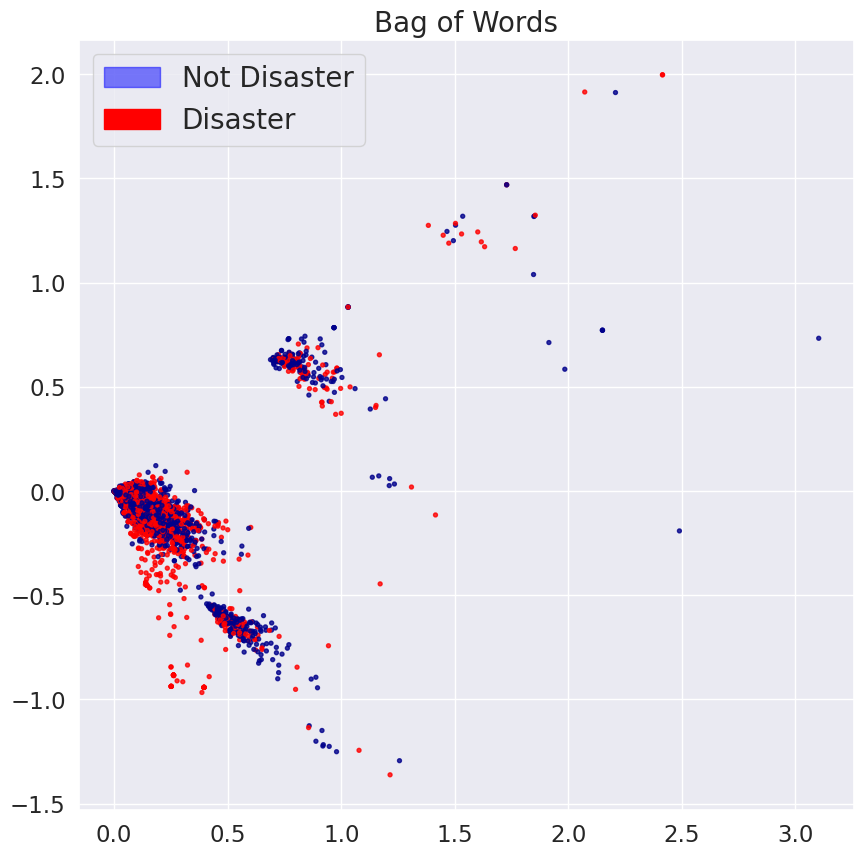

In [ ]:
#PCA

from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['darkblue','red']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='blue', label='Not Disaster', alpha=0.5)
            blue_patch = mpatches.Patch(color='red', label='Disaster')
            plt.legend(handles=[red_patch, blue_patch], prop={'size': 20})


fig = plt.figure(figsize=(10, 10))
plot_LSA(X_train_counts, y_train)
plt.title('Bag of Words', fontsize=20)
plt.show()



По графику видно, что два класса не разделены как следует, возможно это просто эффект сокращения размерности.
Посмотрим какие результаты будут после обучения.

### LogisticRegression & CatBoostClassifier

In [ ]:
# LogisticRegression + Bag of Words
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.807, precision = 0.809, recall = 0.807, f1 = 0.805


In [ ]:
!pip install catboost

In [ ]:
#CatBoostClassifier + Bag of Words
from catboost import CatBoostClassifier

cat_clf = CatBoostClassifier(iterations=300, logging_level='Silent')
cat_clf.fit(X_train_counts, y_train)

y_predicted_cat = cat_clf.predict(X_test_counts)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_cat)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.791, precision = 0.803, recall = 0.791, f1 = 0.785


Ожидала, что `CatBoost` даст показатель f1 выше, однако у `LogisticRegression` f1 = 0.805 - не плохой показатель, попробуем найти, какие ошибки допускает наш классификатор. Давайте начнем с рассмотрения `Confusion Matrix`.

In [24]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          display_labels=["Not Disaster","Disaster"],
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.rcParams.update({'font.size': 20})

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="black" if cm[i, j] < thresh else "white", fontsize=20)


    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

    return plt

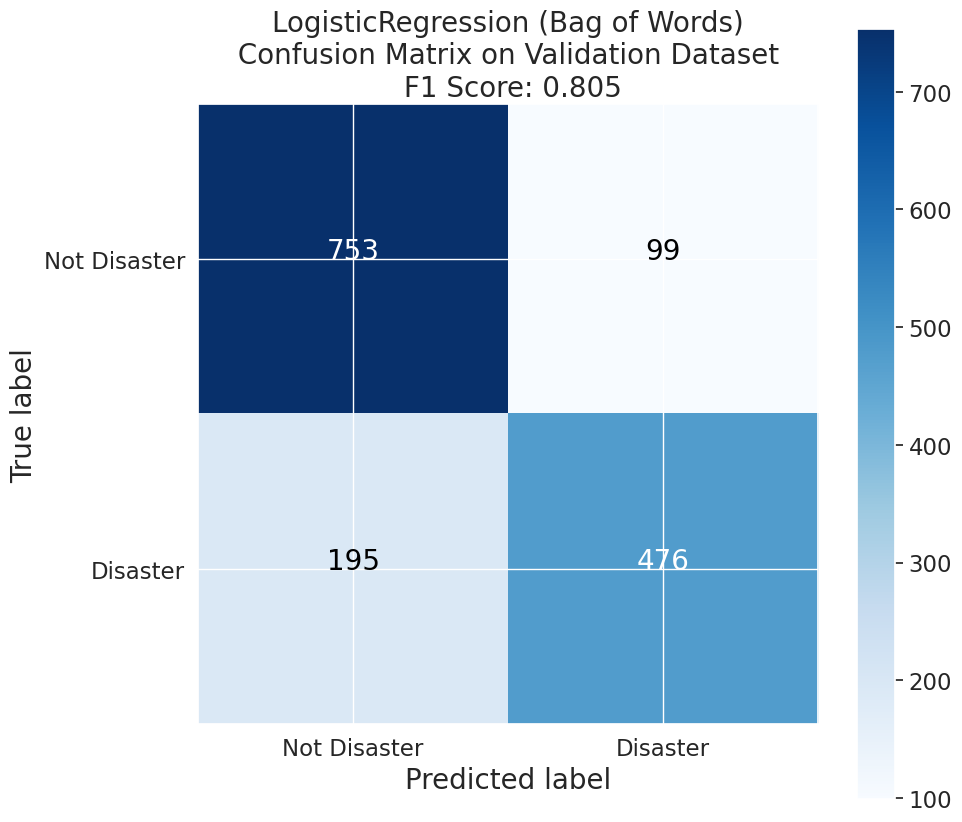

In [ ]:
#LogisticRegression (Bag of Words) - Confusion_matrix

cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Disaster','Disaster'], normalize=False, title='Confusion matrix')
f1_lr_bow = f1_score(y_test, y_predicted_counts, pos_label=None, average='weighted')
plt.grid(False)
plt.title("LogisticRegression (Bag of Words)\n Confusion Matrix on Validation" + " Dataset \n F1 Score: " + str(f1_lr_bow.round(3)),fontsize=20)

plt.show()

Классификатор создает больше ложноотрицательных (TN), чем ложноположительных (FN) срабатываний. В зависимости от варианта использования это кажется желательным (например, ложноположительный результат - довольно высокая стоимость для правоохранительных органов).

Посмотрим на топ-10 слов, с помощью которых построен `Confusion Matrix`

In [ ]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

In [ ]:
print(importance[0],'tops')

{'tops': [(1.6133802401133288, 'japan'), (1.7180091378394768, 'floods'), (1.7423087063054252, 'massacre'), (1.7457084017392155, 'bombing'), (1.8188744849627525, 'derailment'), (1.9802391449625099, 'typhoon'), (2.0694659740230334, 'earthquake'), (2.1461652064494774, 'wildfire'), (2.2872674283808485, 'fires'), (2.507388337593678, 'hiroshima')], 'bottom': [(-1.078967956145386, 'poll'), (-1.079942965107176, 'full'), (-1.0843169781026218, 'harm'), (-1.1020866667353533, 'jobs'), (-1.1142089082135496, 'better'), (-1.177318772832285, 'nowplaying'), (-1.2005635833568018, 'eyes'), (-1.2596318471758632, 'bags'), (-1.3429588514463224, 'love'), (-1.4033461935058344, 'ruin')]} tops


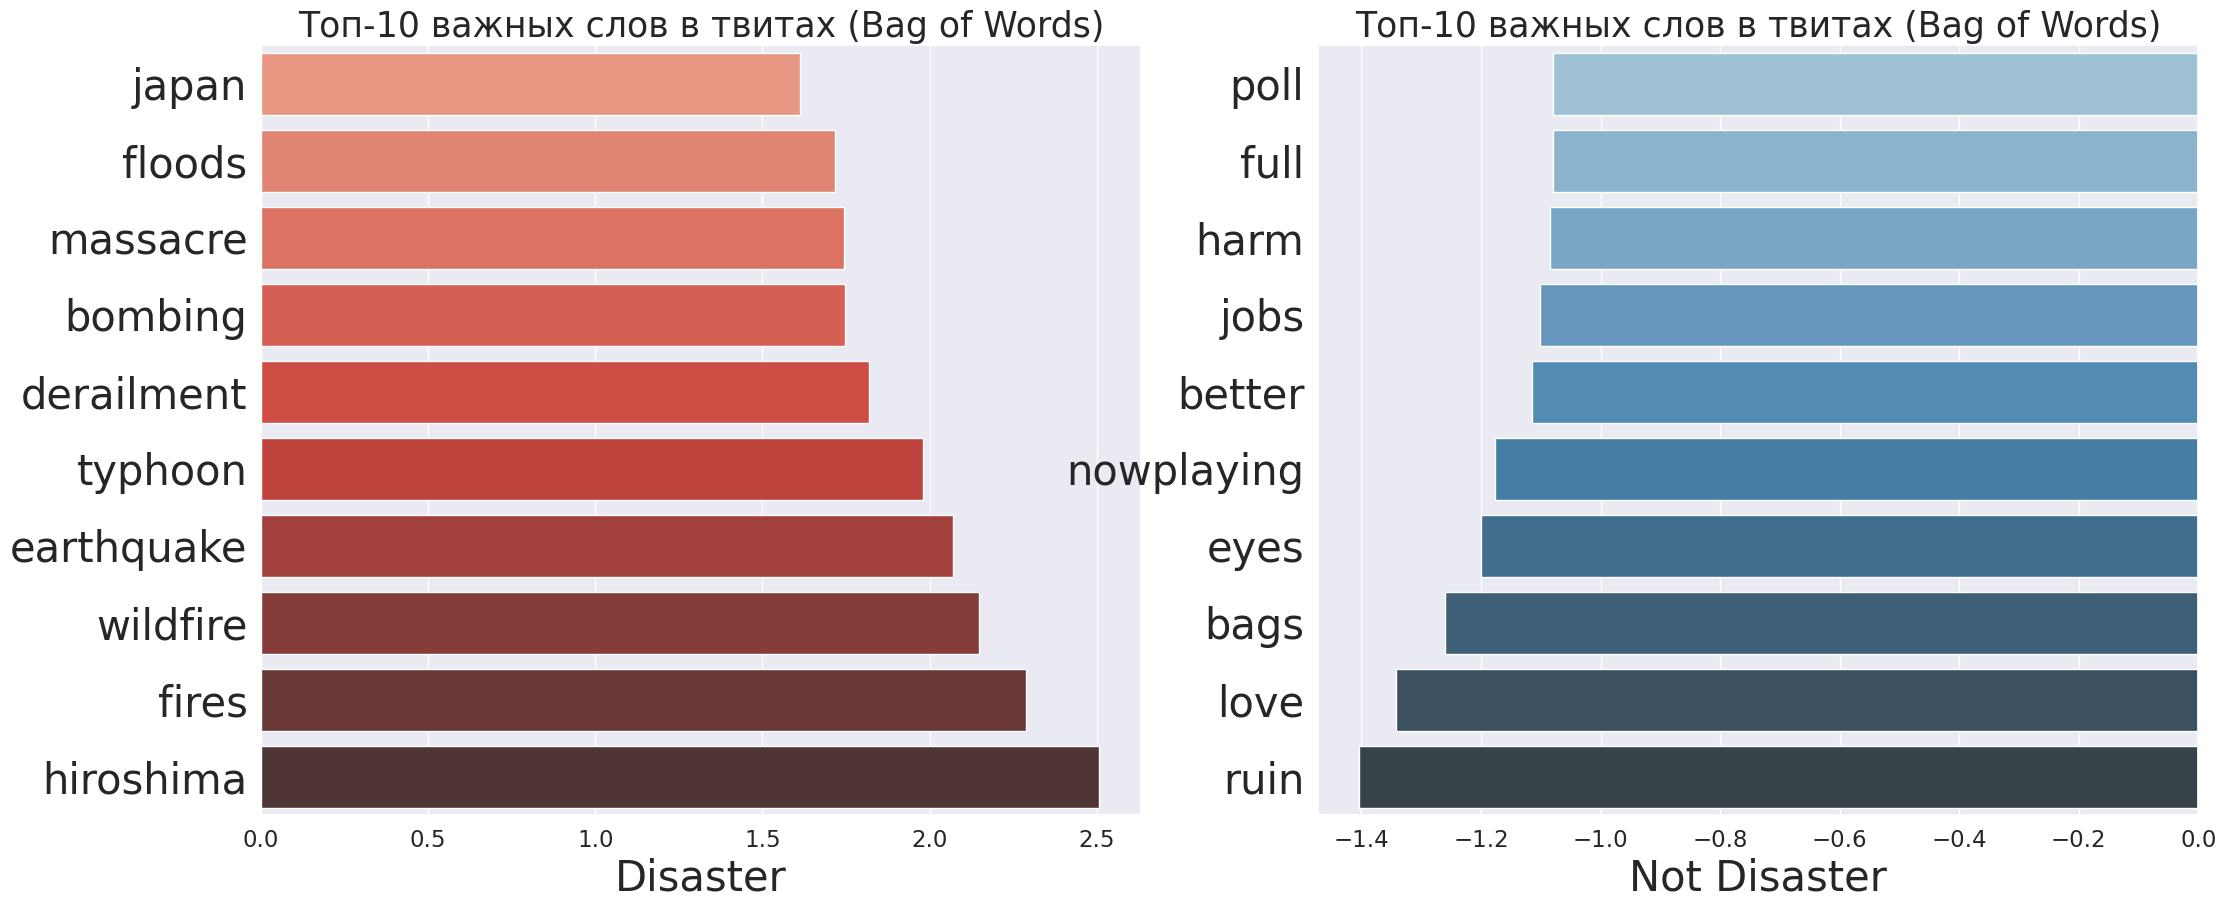

In [ ]:
# Топ-10 слов для модели Bag of Words

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    # left side, the plot for keywords in disastrous tweets
    fig, ax_ = plt.subplots(1, 2, figsize = (25,10))

    sns.barplot(x = top_scores, # count of each keyword
                y = top_words, # index of this df is our keywords
                ax = ax_[0],
                palette = 'Reds_d', label = 'dis').set_title(name, fontsize = 25)
    # right side, the plot for non_disastrous tweets
    sns.barplot(x = bottom_scores, y = bottom_words,
                ax = ax_[1], palette = 'Blues_d', label = 'non_dis').set_title(name, fontsize = 25)

    for ax in [ax_[0], ax_[1]]:
        ax.set_ylabel('')
        ax.set_xlabel('Disaster',fontsize = 30)
        ax.set_yticklabels(labels =ax.get_yticklabels() ,
                       fontsize = 30)

    for ax in [ax_[1]]:
        ax.set_ylabel('')
        ax.set_xlabel('Not Disaster',fontsize = 30 )
        ax.set_yticklabels(labels =ax.get_yticklabels('') ,
                       fontsize = 30)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Топ-10 важных слов в твитах (Bag of Words)")

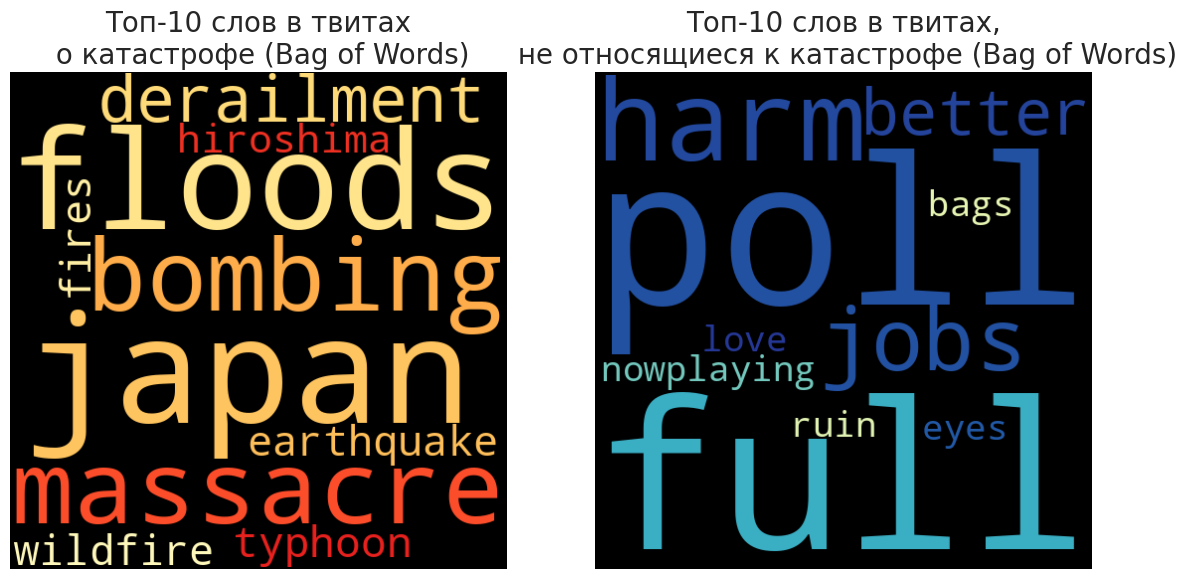

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


#  1.  SUBPLOTS - Create the two word strings
#  Episode IV: A New Hope
wc_string_1 = ' '.join(top_words)

#  Episode V: The Empire Strikes Back
wc_string_2 = ' '.join(bottom_words)



#  2.  SUBPLOTS - Generate the two word clouds
wordcloud_1 = WordCloud(width = 500, height = 500,    # resolution
                  colormap = 'YlOrRd',                # font colors from palette
                  background_color ='black',          # background color
                  #stopwords = stopwords,              # remove common words
                  normalize_plurals = True,           # plurals to singular
                  repeat = False,                      # repeat words
                  min_font_size = 10).generate(wc_string_1)

wordcloud_2 = WordCloud(width = 500, height = 500,    # resolution
                  colormap = 'YlGnBu',                # font colors from palette
                  background_color ='black',          # background color
                  #stopwords = stopwords,              # remove common words
                  normalize_plurals = True,           # plurals to singular
                  repeat = False,                      # repeat words
                  min_font_size = 10).generate(wc_string_2)


#  3.  SUBPLOTS - Plot the two word clouds
fig = plt.figure(figsize=(12,6))

#  subplot #1
plt.subplot(121)
plt.title('Топ-10 слов в твитах\n о катастрофе (Bag of Words)',fontsize=20)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")

#  subplot #2
plt.subplot(122)
plt.title('Топ-10 слов в твитах,\n не относящиеся к катастрофе (Bag of Words)',fontsize=20)
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
#TFIDF
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

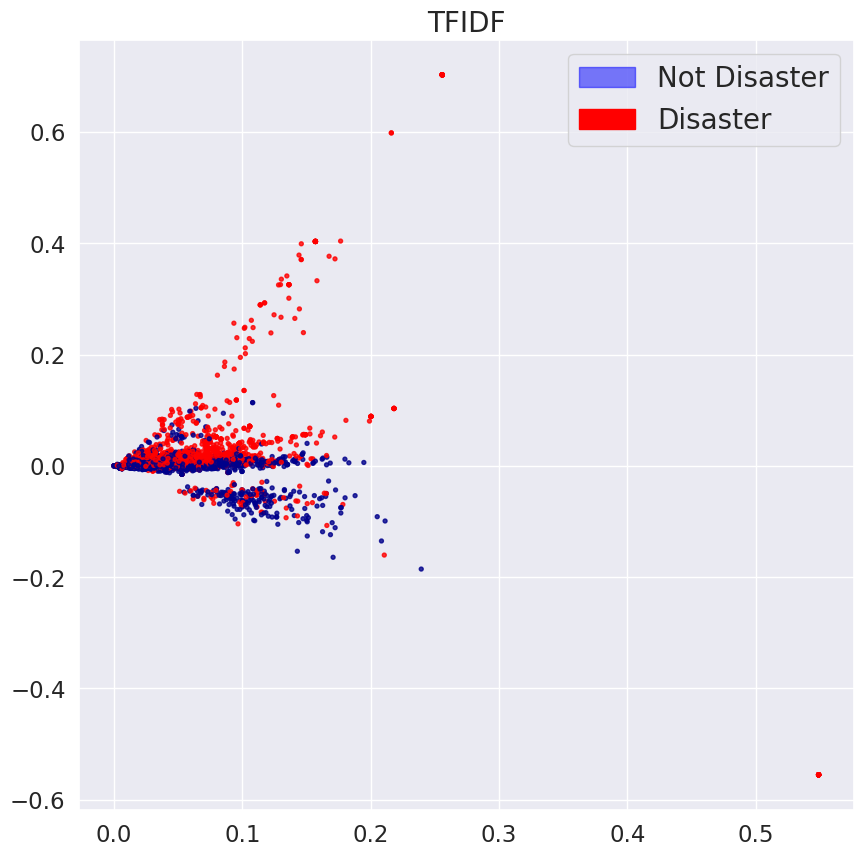

In [ ]:
fig = plt.figure(figsize=(10, 10))
plot_LSA(X_train_tfidf, y_train)
plt.title('TFIDF',fontsize=20)
plt.show()

In [ ]:
#LogisticRegression + TFIDF
clf_tfidf = LogisticRegression()
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf,
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.815, precision = 0.821, recall = 0.815, f1 = 0.812


In [ ]:
#CatBoostClassifier + TFIDF
cat_clf = CatBoostClassifier(iterations=300, logging_level='Silent')
cat_clf.fit(X_train_tfidf, y_train)

y_predicted_cat_tfidf = cat_clf.predict(X_test_tfidf)

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_cat_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf,
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.795, precision = 0.807, recall = 0.795, f1 = 0.789


`LogisticRegression` f1=0,812 показатель чуть лучше с `TFIDF`, построем `Confusion_matrix`

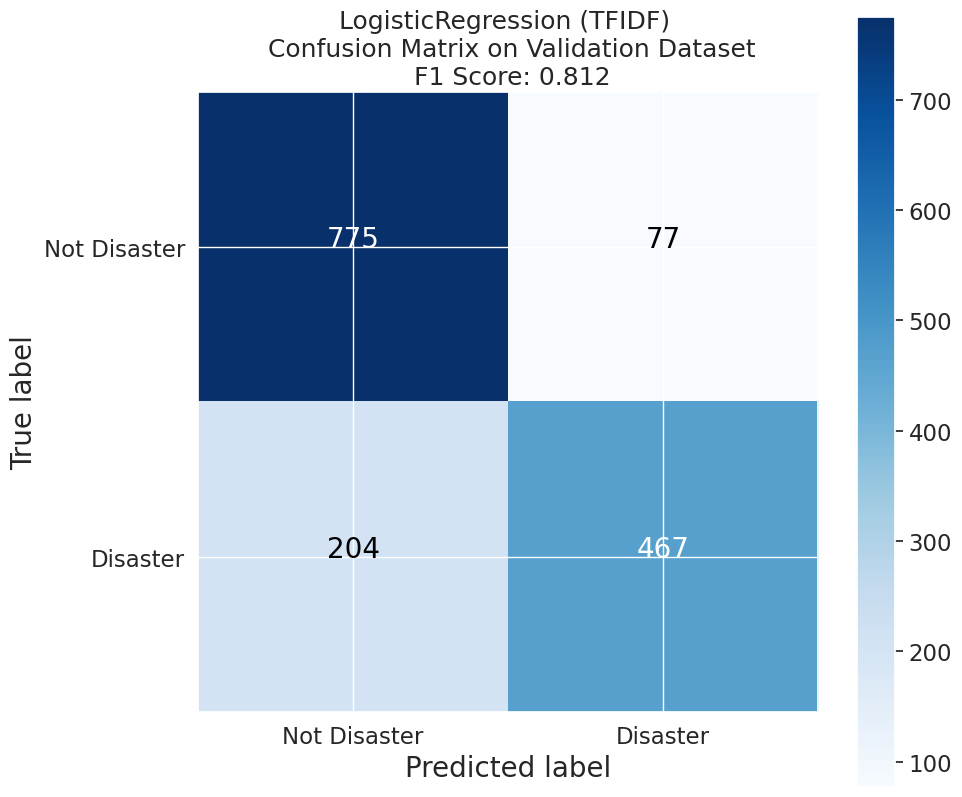

In [ ]:
#LogisticRegression (TFIDF) - Confusion_matrix
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not Disaster','Disaster'], normalize=False, title='Confusion matrix')
f1_lr_tfidf = f1_score(y_test, y_predicted_tfidf, pos_label=None, average='weighted')
plt.title("LogisticRegression (TFIDF) \n Confusion Matrix on Validation" + " Dataset\n F1 Score: " + str(f1_lr_tfidf.round(3)))
plt.show()

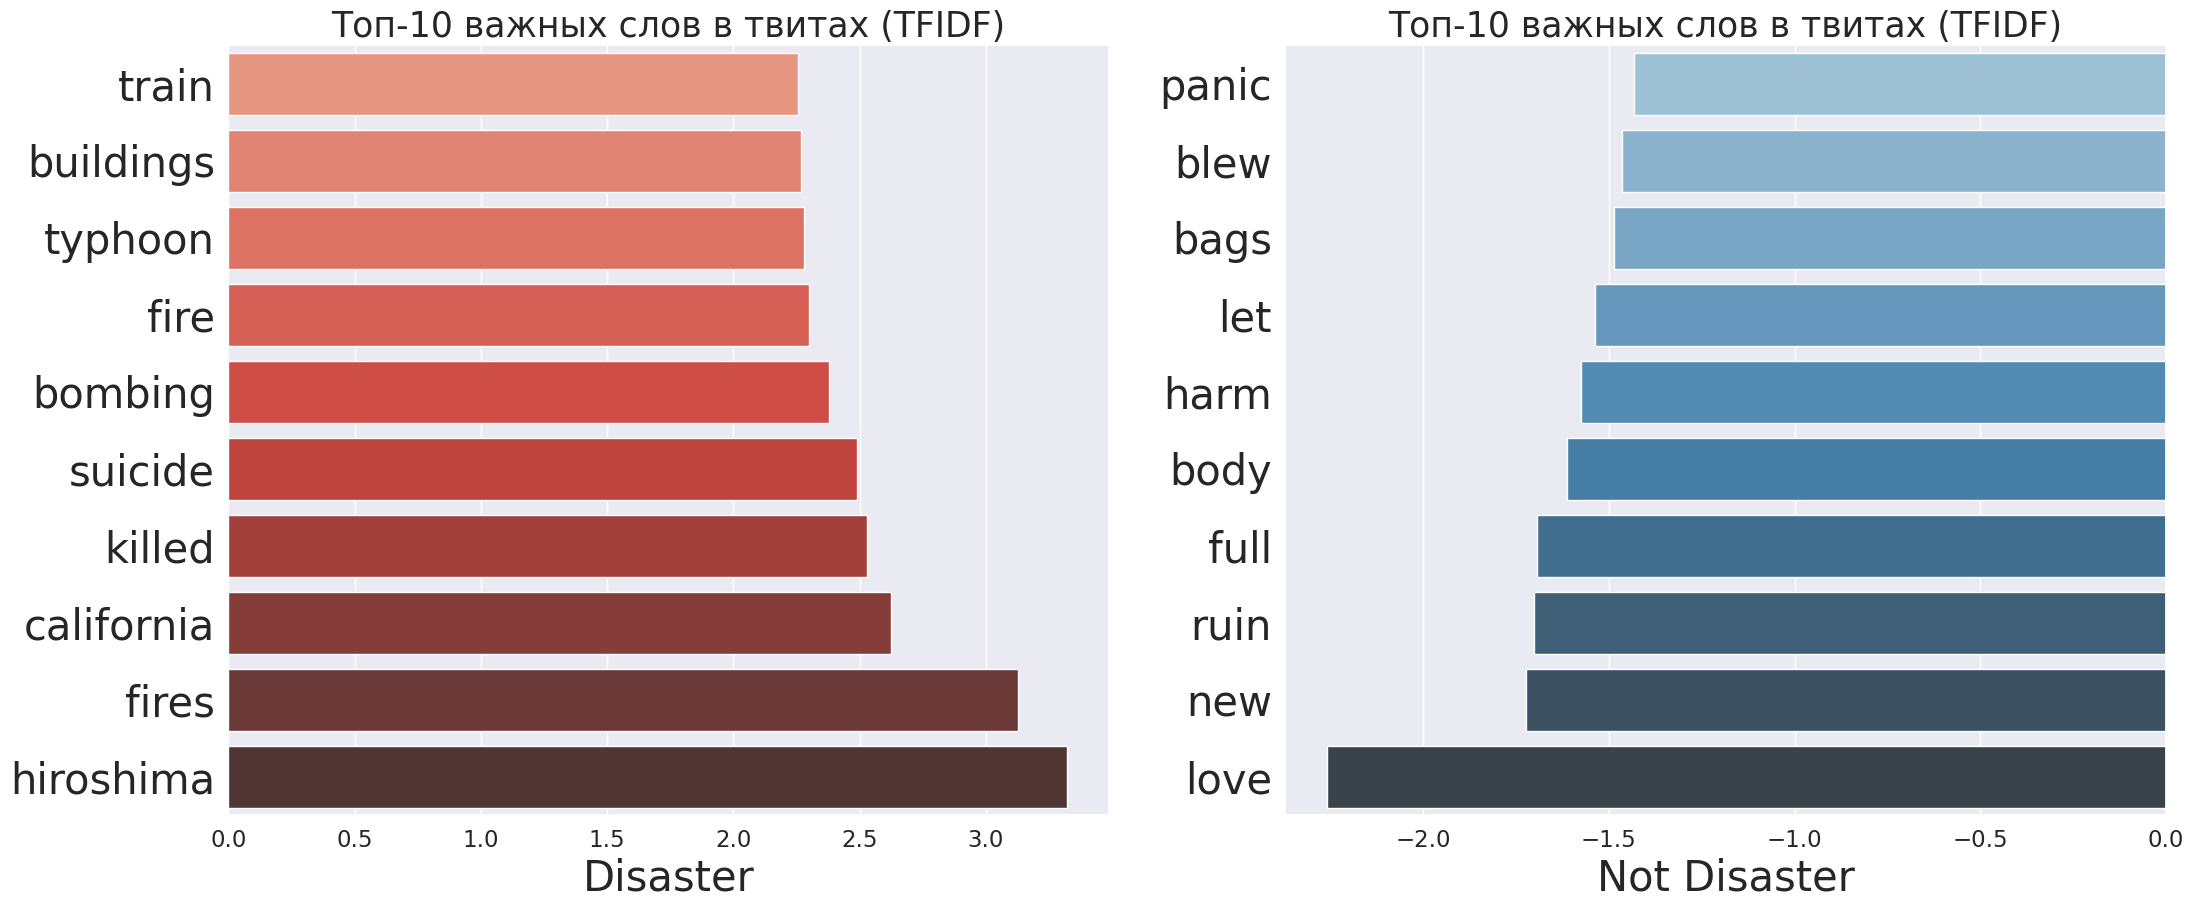

In [ ]:
# Топ-10 слов для модели TFIDF
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Топ-10 важных слов в твитах (TFIDF)")

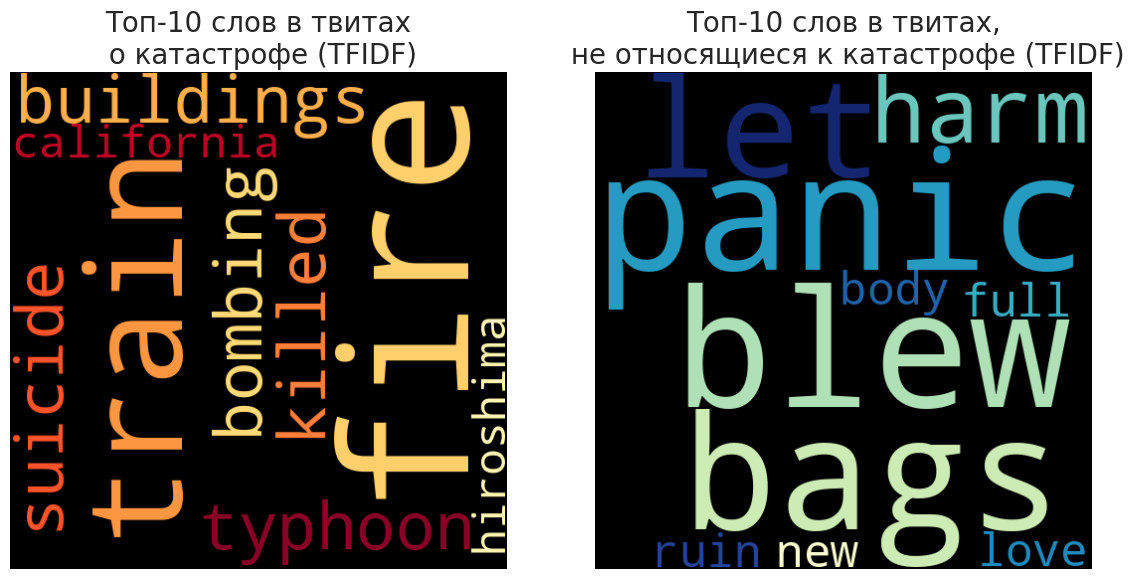

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


#  1.  SUBPLOTS - Create the two word strings
#  Episode IV: A New Hope
wc_string_1 = ' '.join(top_words)

#  Episode V: The Empire Strikes Back
wc_string_2 = ' '.join(bottom_words)



#  2.  SUBPLOTS - Generate the two word clouds
wordcloud_1 = WordCloud(width = 500, height = 500,    # resolution
                  colormap = 'YlOrRd',                # font colors from palette
                  background_color ='black',          # background color
                  #stopwords = stopwords,              # remove common words
                  normalize_plurals = True,           # plurals to singular
                  repeat = False,                      # repeat words
                  min_font_size = 10).generate(wc_string_1)

wordcloud_2 = WordCloud(width = 500, height = 500,    # resolution
                  colormap = 'YlGnBu',                # font colors from palette
                  background_color ='black',          # background color
                  #stopwords = stopwords,              # remove common words
                  normalize_plurals = True,           # plurals to singular
                  repeat = False,                      # repeat words
                  min_font_size = 10).generate(wc_string_2)


#  3.  SUBPLOTS - Plot the two word clouds
fig = plt.figure(figsize=(12,6))

#  subplot #1
plt.subplot(121)
plt.title('Топ-10 слов в твитах\n о катастрофе (TFIDF)', fontsize=20)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")

#  subplot #2
plt.subplot(122)
plt.title('Топ-10 слов в твитах,\n не относящиеся к катастрофе (TFIDF)', fontsize=20)
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()
plt.show()

Построим получится ли уличшить результаты с алгоримом Word2Vec

In [ ]:
import gensim.downloader as api

word2vec = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
#Word2Vec

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, df_train, generate_missing=False):
    embeddings = df_train['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)



In [ ]:
embeddings = get_word2vec_embeddings(word2vec, df_train)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,
                                                                                        test_size=0.2, random_state=40)

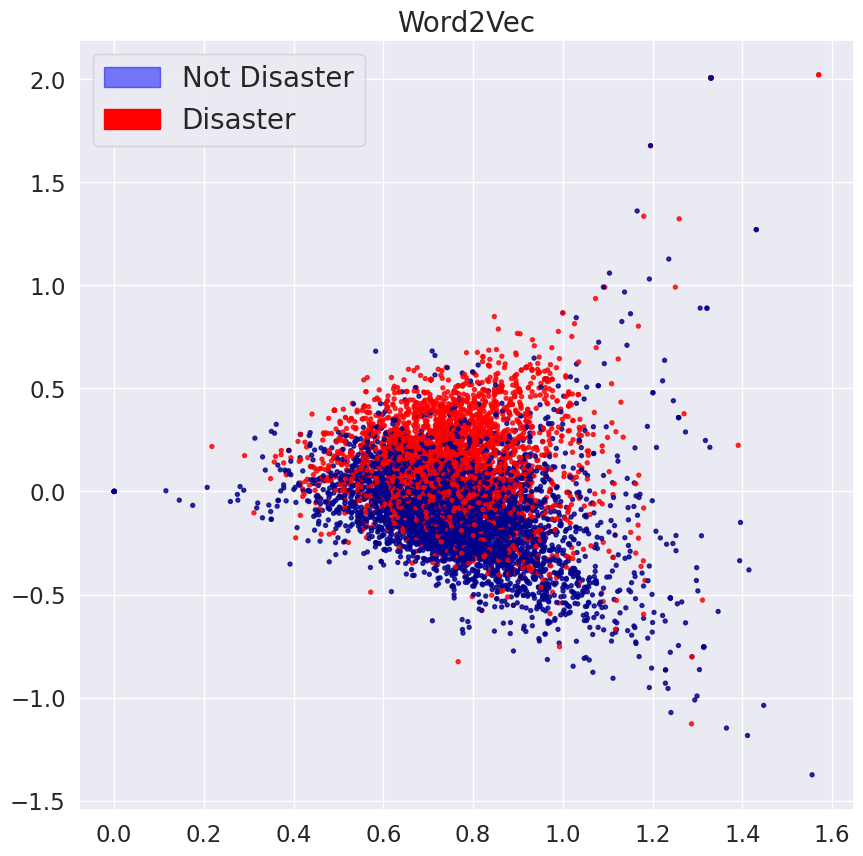

In [ ]:
fig = plt.figure(figsize=(10, 10))
plot_LSA(embeddings, list_labels)
plt.title('Word2Vec', fontsize=20)
plt.show()

In [ ]:
#LogisticRegression + Word2Vec
clf_w2v = LogisticRegression()
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec,
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.798, precision = 0.799, recall = 0.798, f1 = 0.796


In [ ]:
#CatBoostClassifier + Word2Vec
cat_clf = CatBoostClassifier(iterations=300, logging_level='Silent')
cat_clf.fit(X_train_word2vec, y_train_word2vec)

y_predicted_cat_word2vec= cat_clf.predict(X_test_word2vec)

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_cat_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec,
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.815, precision = 0.817, recall = 0.815, f1 = 0.813


`CatBoostClassifier` с `Word2Vec` показал довольно не плохой результат f=0.813, почти аналогичный результату `LogisticRegression` с `TFIDF` (f=0.812).

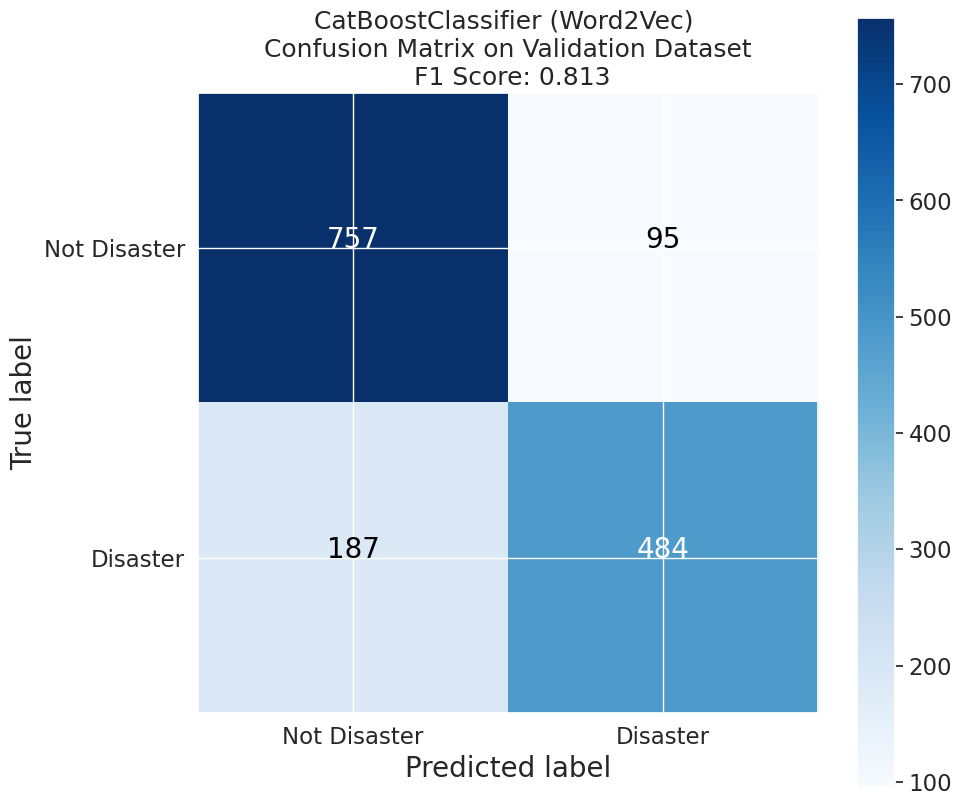

In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_cat_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['Not Disaster','Disaster'], normalize=False, title='Confusion matrix')
f1_cat = f1_score(y_test_word2vec, y_predicted_cat_word2vec, pos_label=None, average='weighted')
plt.title("CatBoostClassifier (Word2Vec) \n Confusion Matrix on Validation" + " Dataset \n F1 Score: " + str(f1_cat.round(3)))
plt.show()

In [ ]:
pip install lime

In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [ ]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Not Disaster","Disaster"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [ ]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()

    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)

    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)

        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]

    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Not Disaster',
    1: 'Disaster'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

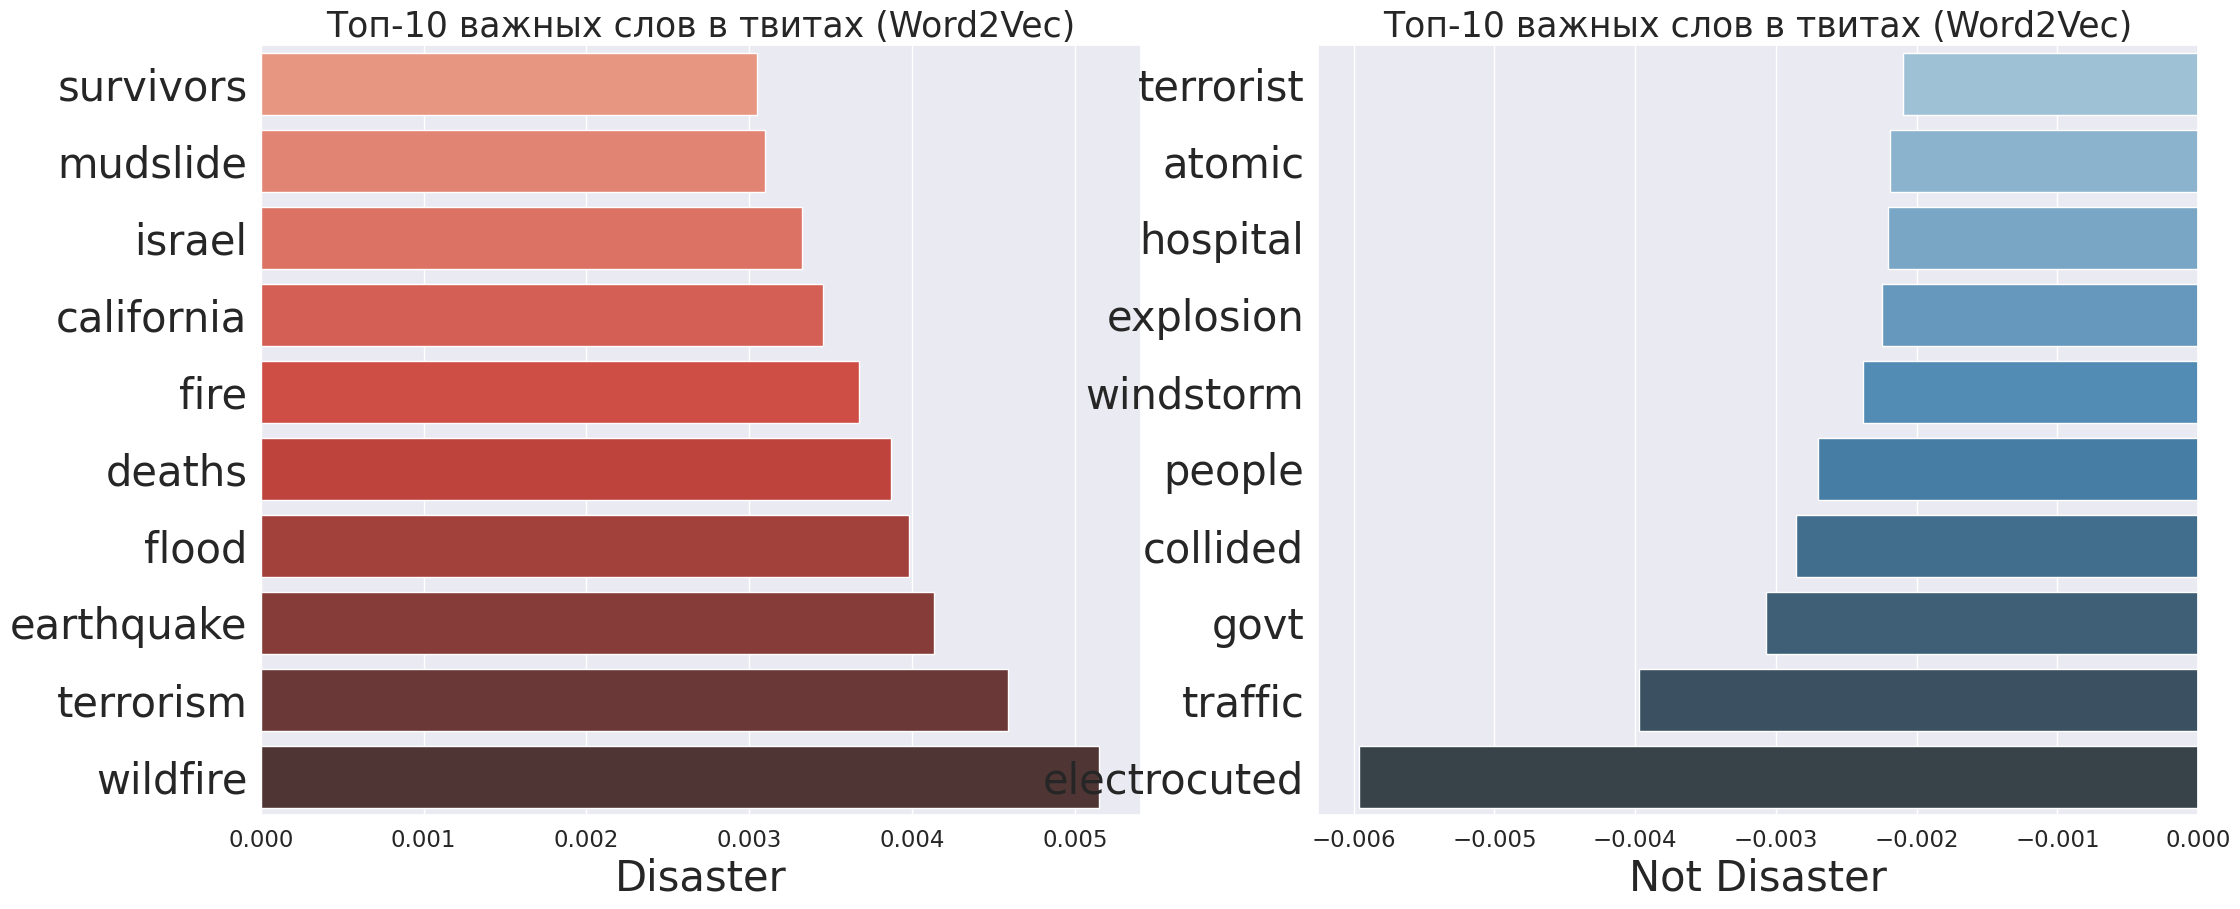

In [ ]:
top_words = sorted_contributions['Disaster']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Disaster']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Not Disaster']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Not Disaster']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Топ-10 важных слов в твитах (Word2Vec)")

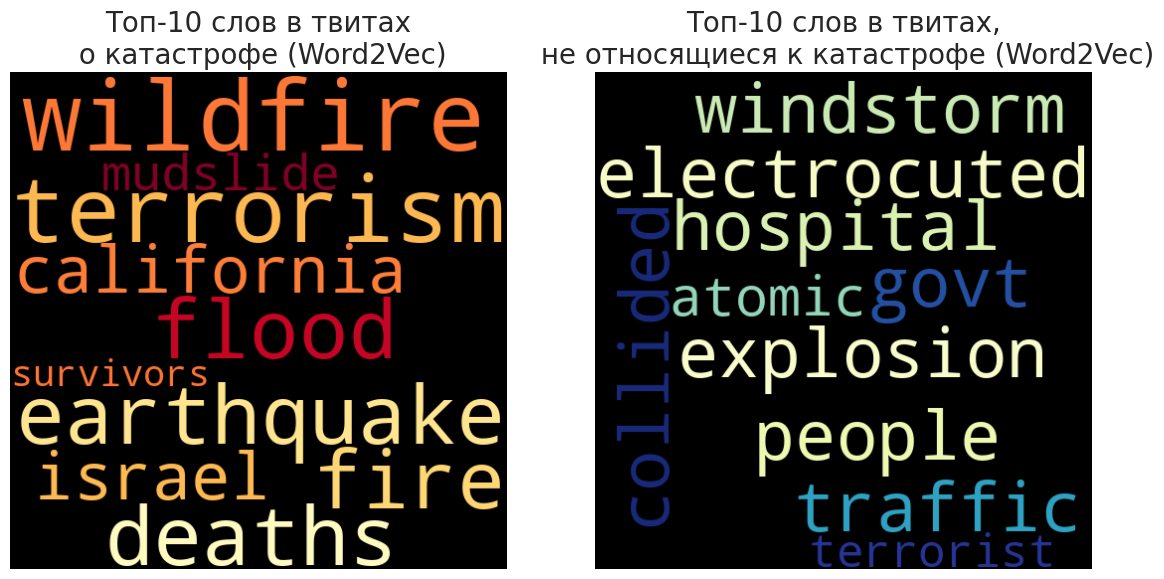

In [ ]:
# Топ-10 слов для модели Word2Vec

#  1.  SUBPLOTS - Create the two word strings
#  Episode IV: A New Hope
wc_string_1 = ' '.join(top_words)

#  Episode V: The Empire Strikes Back
wc_string_2 = ' '.join(bottom_words)



#  2.  SUBPLOTS - Generate the two word clouds
wordcloud_1 = WordCloud(width = 500, height = 500,    # resolution
                  colormap = 'YlOrRd',                # font colors from palette
                  background_color ='black',          # background color
                  #stopwords = stopwords,              # remove common words
                  normalize_plurals = True,           # plurals to singular
                  repeat = False,                      # repeat words
                  min_font_size = 10).generate(wc_string_1)

wordcloud_2 = WordCloud(width = 500, height = 500,    # resolution
                  colormap = 'YlGnBu',                # font colors from palette
                  background_color ='black',          # background color
                  #stopwords = stopwords,              # remove common words
                  normalize_plurals = True,           # plurals to singular
                  repeat = False,                      # repeat words
                  min_font_size = 10).generate(wc_string_2)


#  3.  SUBPLOTS - Plot the two word clouds
fig = plt.figure(figsize=(12,6))

#  subplot #1
plt.subplot(121)
plt.title('Топ-10 слов в твитах\n о катастрофе (Word2Vec)',fontsize=20)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")

#  subplot #2
plt.subplot(122)
plt.title('Топ-10 слов в твитах,\n не относящиеся к катастрофе (Word2Vec)',fontsize=20)
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()
plt.show()

### BertForSequenceClassification

Для модели BertForSequenceClassification, сохраняются все стоп-слова для предоставления достаточной контекстной информации, например, слова отрицания (not, nor, never), которые считаются стоп-словами.

In [59]:
#Удалим все нерелевантные символы

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"@\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"#", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"@", "at", regex=True)
    df[text_field] = df[text_field].str.replace(r"%20", "at", regex=True)
    df[text_field] = df[text_field].str.lower()
    return df

train = standardize_text(train, "text")

train.to_csv("clean_train.csv")
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1


In [60]:
from sklearn.model_selection import train_test_split

X = train['text']
y = train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

In [61]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

#tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
#model = BertForSequenceClassification.from_pretrained('distilbert/distilbert-base-uncased')

# Tokenize and encode the training data
train_inputs = tokenizer(list(X_train), padding=True, truncation=True, return_tensors='pt')
train_labels = torch.tensor(list(y_train))

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
from torch.utils.data import TensorDataset, random_split

val_inputs = tokenizer(list(X_val), padding=True, truncation=True, return_tensors='pt')
val_labels = torch.tensor(list(y_val))

# Tokenize and encode the test data
test_inputs = tokenizer(list(df_test['text']), padding=True, truncation=True, return_tensors='pt')

# Create DataLoader for efficient processing
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'])

#train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
#val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
#test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [63]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [64]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [65]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [66]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [67]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):

    """A function for calculating accuracy scores"""

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):

    """A function for calculating f1 scores"""

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return f1_score(labels_flat, pred_flat)

In [68]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [69]:
import random
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Report the final f1 score for this validation run.
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:15.
  Batch    80  of    191.    Elapsed: 0:00:31.
  Batch   120  of    191.    Elapsed: 0:00:47.
  Batch   160  of    191.    Elapsed: 0:01:02.

  Average training loss: 0.47
  Training epcoh took: 0:01:13

Running Validation...
  Accuracy: 0.84
  F1: 0.80
  Validation Loss: 0.39
  Validation took: 0:00:05

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:15.
  Batch    80  of    191.    Elapsed: 0:00:30.
  Batch   120  of    191.    Elapsed: 0:00:46.
  Batch   160  of    191.    Elapsed: 0:01:01.

  Average training loss: 0.34
  Training epcoh took: 0:01:13

Running Validation...
  Accuracy: 0.83
  F1: 0.80
  Validation Loss: 0.43
  Validation took: 0:00:05

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:15.
  Batch    80  of    191.    Elapsed: 0:00:30.
  Batch   120  of    191.    Elapsed: 0:00:46.
  Batch   160  of    191. 

In [70]:
import pandas as pd

# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1,Training Time,Validation Time
epoch,,,,,,
1,0.466587,0.390192,0.836554,0.798458,0:01:13,0:00:05
2,0.337439,0.431475,0.829598,0.801458,0:01:13,0:00:05
3,0.263429,0.430271,0.834807,0.798535,0:01:13,0:00:05


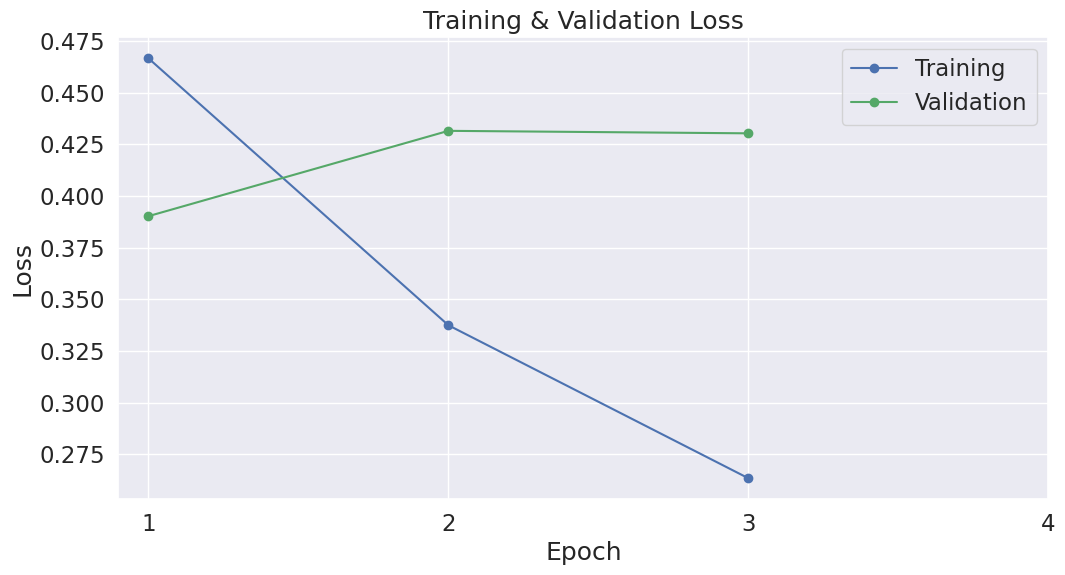

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [72]:
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import confusion_matrix

model.eval()
val_preds = []
with torch.no_grad():
    for batch in tqdm(validation_dataloader, desc='Validation'):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)
        val_preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())

# Evaluate the model
print("Classification Report:")
print(classification_report(y_val, val_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_val, val_preds))
print("F1 Score:", f1_score(y_val, val_preds))

Validation: 100%|██████████| 48/48 [00:04<00:00, 10.12it/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       874
           1       0.82      0.78      0.80       649

    accuracy                           0.84      1523
   macro avg       0.83      0.83      0.83      1523
weighted avg       0.83      0.84      0.83      1523

Confusion Matrix:
[[766 108]
 [143 506]]
F1 Score: 0.8012668250197941


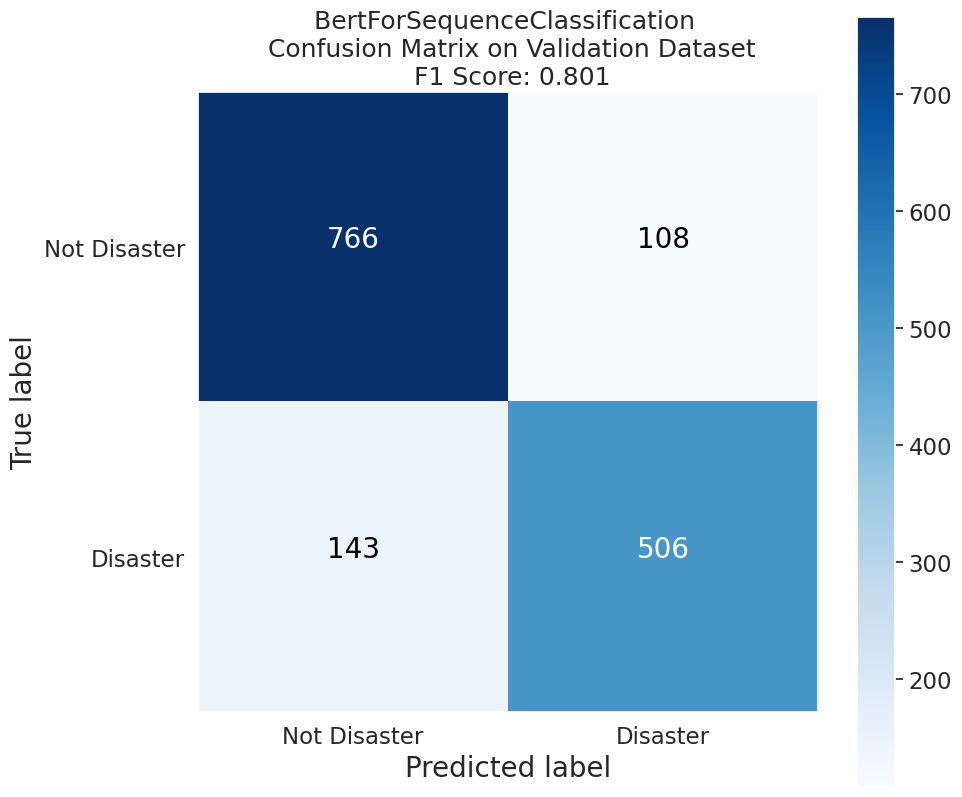

In [73]:
cm4 = confusion_matrix(y_val, val_preds)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm4, classes=['Not Disaster','Disaster'], normalize=False, title='Confusion matrix')
f1_lr_tfidf = f1_score(y_val, val_preds, pos_label=None, average='weighted')
plt.grid(False)
plt.title("BertForSequenceClassification \n Confusion Matrix on Validation" + " Dataset\n F1 Score: " + str(f1_score(y_val, val_preds).round(3)))
plt.show()

Для оценки эффективности моделей использована матрица ошибок.
Несмотря на то, что  F1 Score практически одинаковый для данных моделей,  предсказание False Negative на много меньше у модели BertForSequenceClassification, что в данной работе имеет большое значение.